# Power System Load Forecasting Based on Auto-ARIMA
## Introduction and background
This is a dataset I got from my boss during my internship at Jingdong Technology. My group was responsible for providing energy companies with digitization solutions. I was fortunate to have CSPG(China Southern Power Grid) as a client and they agreed to provide me with desensitized data of a city's power system load from 2018 to 2021 on a daily baisis. 
My goal is to predict the power system goal based on the previous data for the next three months. Predicting future power load is essential is every aspect: power plants need to plan ahead how they run the plant units, while the power grid requires long-term predictions to guarantee elctricty supply for industries and civil use, and to expand or improve the power grid itself.
Since the data I have is a pure time series, which means that with one variable changing through time, I will fit the ARIMA model.

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
import warnings  # Supress warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
np.random.seed(7)


In [3]:
#data_path = os.path.join(os.getcwd(), "Power_Data.csv")
df = pd.read_csv("Power_Data.csv", encoding="gbk")
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Power_Data.csv'

In [3]:
df  = df.rename(columns={'日期':'date'})
df

,date,Total Active Power/kW
0,2018/1/1 0:00,243785.6581
1,2018/1/2 0:00,232099.6895
2,2018/1/3 0:00,231957.6742
3,2018/1/4 0:00,227634.8928
4,2018/1/5 0:00,233586.9766
...,...,...
1431,2021/12/2 0:00,441228.1877
1432,2021/12/3 0:00,438360.3205
1433,2021/12/4 0:00,430629.5873
1434,2021/12/5 0:00,425929.3018


# Formats

Before we begin any exploration, we should first use datetime to change the format of date to datetime. It seems that the space between two entries is exactly one day.

In [4]:
#change format
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'])
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,Total Active Power/kW
0,2018-01-01 00:00:00,243785.658100
1,2018-01-02 00:00:00,232099.689500
2,2018-01-03 00:00:00,231957.674200
3,2018-01-04 00:00:00,227634.892800
4,2018-01-05 00:00:00,233586.976600


In [5]:
# To compelte the data, as naive method, we will use fill
'''
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2018, 1, 1), date(2021, 12, 6)])   
'''

"\nf, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))\n#图片间距可以调\n\nfor i, column in enumerate(df.drop('date', axis=1).columns):\n    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')\n    ax[i].set_title('Feature: {}'.format(column), fontsize=14)\n    ax[i].set_ylabel(ylabel=column, fontsize=14)\n                      \n    ax[i].set_xlim([date(2018, 1, 1), date(2021, 12, 6)])   \n"

In [6]:
df = df.sort_values(by='date')
# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

,date,delta
0,2018-01-01,NaT
1,2018-01-02,1 days
2,2018-01-03,1 days
3,2018-01-04,1 days
4,2018-01-05,1 days


In [7]:
df['delta'].sum(), df['delta'].count()

(Timedelta('1435 days 00:00:00'), 1435)

In [8]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                      0
Total Active Power/kW    54
dtype: int64

# Missing values
We will check if there's any missing values and the missing ones will be shown in red.

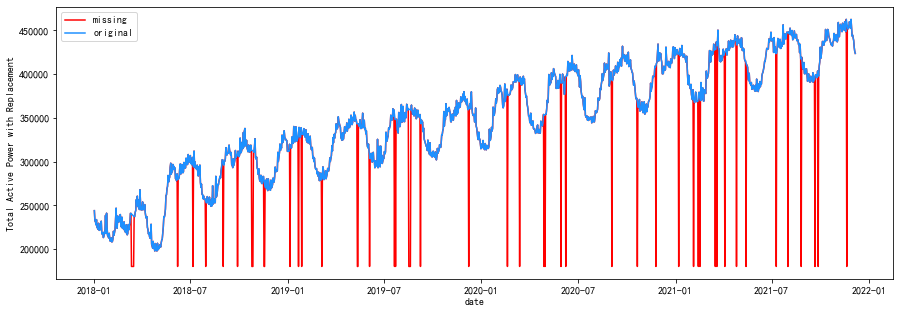

In [9]:
#Let's see if there's any missing values; they will be lined in red
f, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
df['Total Active Power with Replacement'] = df['Total Active Power/kW'].replace(np.nan, 180000)
#df['Total Active Power with Replacement'] 
#ol = df[df['Total Active Power with Replacement']==180000]['Total Active Power with Replacement']
#ol
sns.lineplot(x=df['date'], y=df['Total Active Power with Replacement'], color='red', label='missing')
sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].fillna(np.inf), color='dodgerblue', label='original')

#ax.set_title('Feature: 总有功功率（kw）', fontsize=14)
#sns.set_ylabel(ylabel='总有功功率（kw）', fontsize=14)
#sns.set_xlim([date(2018, 1, 1), date(2021, 12, 6)])

In [10]:
'''
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
o = df['最高温度'].copy()
df['最高温度'] = df['最高温度'].replace(0, np.nan)
sns.lineplot(x=df['date'], y=o, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['最高温度'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: 最高温度', fontsize=14)
ax[1].set_ylabel(ylabel='最高温度', fontsize=14)
ax[1].set_xlim([date(2018, 1, 1), date(2018, 1, 15)])
'''

"\nf, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))\no = df['最高温度'].copy()\ndf['最高温度'] = df['最高温度'].replace(0, np.nan)\nsns.lineplot(x=df['date'], y=o, ax=ax[1], color='darkorange', label='original')\nsns.lineplot(x=df['date'], y=df['最高温度'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')\nax[1].set_title('Feature: 最高温度', fontsize=14)\nax[1].set_ylabel(ylabel='最高温度', fontsize=14)\nax[1].set_xlim([date(2018, 1, 1), date(2018, 1, 15)])\n"

In [11]:
# 缺失值处理(多种填充方式)

KeyError: 'Total Active Power/kW）'

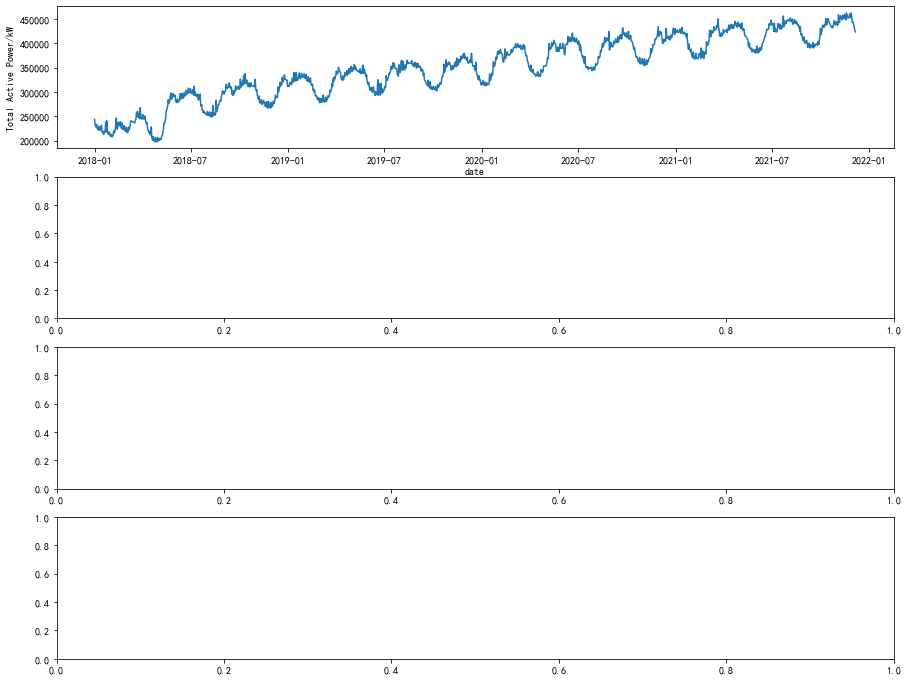

In [12]:
#use different type of ffill
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['Total Active Power/kW'], ax=ax[0])
sns.lineplot(x=df['date'], y=df['Total Active Power/kW）'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume', fontsize=14)

mean_drainage = df['Total Active Power/kW'].mean()
sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['Total Active Power/kW'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2018, 1, 1), date(2021, 12, 6)])
    
plt.tight_layout()
plt.show()

In [ ]:
#use interpolate
df['Total Active Power/kW'] = df['Total Active Power/kW'].interpolate()

# Visualization

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
#df.head()
df['date'] = pd.to_datetime(df['date'])
total_active = df['Total Active Power/kW']
decomposition = seasonal_decompose(total_active, model='multiplicative', period = 100)
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

# Resampling

Test if downsample can help.

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16,8))

sns.lineplot(df['date'], df['Total Active Power/kW'], color='dodgerblue', ax=ax[0])
ax[0].set_title('Total Active Power/kw', fontsize=14)

#resample处理时间序列数据专用，前两列是要选出来的列，1D是指间隔1D resample一次，必须on date
#resampled_df = df[['date','总有功功率（kw）']].resample('1D', on='date').sum().reset_index(drop=False)

resampled_df = df[['date','Total Active Power/kW']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['Total Active Power/kW'], color='dodgerblue', ax=ax[1])
ax[1].set_title('Weekly Total Active Power/kw', fontsize=14)
resampled_df = df[['date','Total Active Power/kW']].resample('1M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['Total Active Power/kW'], color='dodgerblue', ax=ax[2])
ax[2].set_title('Monthly Total Active Power/kw', fontsize=14)
for i in range(3):
    ax[i].set_xlim([date(2018, 1, 1), date(2021, 12, 6)])


As we can see, downsample to weekly could smooth the data and help with analysis.

In [ ]:
#准备downsample到1m
downsample = df[['date',
                 'Total Active Power/kW', 
                ]].resample('7D', on='date').mean().reset_index(drop=False)

In [ ]:
#plt.plot(downsample)
#plt.show()
downsample

# Stationarity test

In this part we will guarantee that this time series is stationarity. First we will plot the TS and check if there is a trend or seasonality.

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(downsample['date'], downsample['Total Active Power/kW'], label='Original')
axes[0][0].plot(downsample['date'], downsample['Total Active Power/kW'].rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Total Active Power/kW")
axes[0][0].set_title("4-Weeks Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(downsample['date'], downsample['Total Active Power/kW'], label='Original')
axes[0][1].plot(downsample['date'], downsample['Total Active Power/kW'].rolling(window=24).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Total Active Power/kW")
axes[0][1].set_title("24-Weeks Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(downsample['date'], downsample['Total Active Power/kW'], label='Original')
axes[1][0].plot(downsample['date'], downsample['Total Active Power/kW'].rolling(window=48).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Total Active Power/kW")
axes[1][0].set_title("48 Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(downsample['date'], downsample['Total Active Power/kW'], label='Original')
axes[1][1].plot(downsample['date'], downsample['Total Active Power/kW'].rolling(window=52).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Total Active Power/kW")
axes[1][1].set_title("52-Weeks Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

In the plot, it seems that the total active power follows a cycle of approximately 2 days, but there is still a rapid dive near 2018-1-11, thus we cannot conclude that this TS is stationary. Besides, the rolling standard deviation is also non-constant. 

Now we will run the ADF test on the timeseries and verify the null hypothesis that the time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Total Active Power/kW'].values)
dfoutput = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

# Transform

We log transform the data to make it stationary on variance

In [ ]:
df['Total Active Power/kW_log'] = np.log(abs(df['Total Active Power/kW']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['Total Active Power/kW_log'], 'Transformed', ax[0])

sns.distplot(df['Total Active Power/kW_log'], ax=ax[1])

We will use first order differencing to make data stationary on mean.

In [ ]:
# First Order Differencing based on log
ts_diff = np.diff(df['Total Active Power/kW_log'])
df['Total Active Power/kW_diff_1'] = np.append([0], ts_diff)

In [ ]:
result_diff = adfuller(df['Total Active Power/kW）_diff_1'].values)
#df['总有功功率（kw）_diff_1']
dfoutput_diff = pd.Series(result_diff[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in result_diff[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput_diff)

#seems fair so the i part of ARIMA = 1; first differencing is enough
#i=1

# Identify potential AR and MA model
Now the data is stationary on both mean and variance, we can create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data.
The seasonality is Relatively constant

# Self-correlation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['总有功功率（kw）_diff_1'], lags=50, ax=ax[0])
plot_pacf(df['总有功功率（kw）_diff_1'], lags=50, ax=ax[1])

plt.show()

# Univariate Time Series Model

In [ ]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
df = df.fillna(0)
univariate_df = df[['date', '总有功功率（kw）']].copy()
univariate_df.columns = ['ds', 'Total Active Power']
univariate_df['ds'] = pd.to_datetime(univariate_df['ds'])
df1 = univariate_df.set_index('ds', inplace = True)
train = univariate_df.iloc[480:train_size, :]
test = univariate_df.iloc[train_size:, :]
#train.set_index('ds')
#test.set_index('ds')
#x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
#x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

#print(len(train), len(x_valid))

In [ ]:
train_size1 = int(0.85 * len(downsample))
test_size1 = len(downsample) - train_size
#downsample.columns = ['ds', 'Total Active Power']
#downsample['date'] = pd.to_datetime(downsample['date'])
downsample1 = downsample.set_index('date')
train1 = downsample1.iloc[48:train_size1, :]
test1 = downsample1.iloc[train_size1:, :]

In [ ]:
y2 = pd.DataFrame(univariate_df['Total Active Power'])
y3 = pd.DataFrame(df['总有功功率（kw）'])
#y2.plot()

# ARIMA

In [ ]:

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model = sm.tsa.statespace.SARIMAX(
    train1, 
    order=(1, 0, 2),
    seasonal_order=(1, 1, 2, 15)
).fit()

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
'''
import pmdarima as pm
SARIMA_model = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, 
                         m=24, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
'''

In [ ]:
model.summary()

In [ ]:
model.plot_diagnostics()


In [ ]:
prediction = pd.DataFrame(model.predict(start = '2021-05-10', end = '2021-12-06'), index = test1.index)
prediction.columns = ['predicted']
#prediction

In [ ]:
forecast = pd.DataFrame(model.predict(start = '2021-12-13', end = '2022-3-30'))
#forecast1 = pd.DataFrame(model.get_forecast(start = '2021-12-13', end = '2022-3-30', alpha = 0.05))

In [ ]:
#train

In [ ]:
plt.plot(training1, label = 'Training')
plt.plot(test1, label = 'Test')
plt.plot(prediction, label = "Predicted")
plt.legend(loc ='best')
plt.show()

# Using the ARIMA model to forecast


In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()
ax = downsample1['2018-01':].plot(ax=ax)
plot_predict(model, start = '2021-12-13', end = '2022-3-30', dynamic = True, ax=ax, plot_insample=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Active Power/kW', fontsize=14)
plt.show()